In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from osgeo import gdal,ogr,osr

In [2]:

img_file = "MasterThesisRCode/data/rectified/ang20190712t231624_rfl_v2v2_img_rectified"
hdr_file = f"{img_file}.hdr"
print(img_file)
print(hdr_file)

MasterThesisRCode/data/rectified/ang20190712t231624_rfl_v2v2_img_rectified
MasterThesisRCode/data/rectified/ang20190712t231624_rfl_v2v2_img_rectified.hdr


In [3]:
# open the hyperspectral image file with GDAL
img_open = gdal.Open(img_file)

# read a few key properties of the image
nbands = img_open.RasterCount
ncols = img_open.RasterXSize
nrows = img_open.RasterYSize

print("\n".join(["Bands:\t"+str(nbands),"Cols (x-axis):\t"+str(ncols),"Rows (y-axis):\t"+str(nrows)]))

Bands:	425
Cols (x-axis):	1065
Rows (y-axis):	1144


In [4]:
# Initialize an array to hold the data with NaNs for no-data values
hyperspectral_data = np.empty((nbands, nrows, ncols), dtype=np.float32)

# Loop through each band and replace -9999 with NaN
for i in range(nbands):
    band = img_open.GetRasterBand(i + 1)
    band_data = band.ReadAsArray().astype(np.float32)  # Read as float32 to allow NaNs
    
    # Replace all -9999 values with NaN
    band_data[band_data == -9999] = np.nan
    
    # Store the modified band data in the hyperspectral_data array
    hyperspectral_data[i, :, :] = band_data

# Check one of the bands to verify
print(hyperspectral_data[0])  # Print first band with NaNs replacing -9999 values

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
# band descriptions. we reference this dictionary throughout the tutorial.
band_dictionary = {
    "visible-violet": {'lower': 375, 'upper': 450, 'color': 'violet'},
    "visible-blue": {'lower': 450, 'upper': 485, 'color': 'blue'},
    "visible-cyan": {'lower': 485, 'upper': 500, 'color': 'cyan'},
    "visible-green": {'lower': 500, 'upper': 565, 'color': 'green'},
    "visible-yellow": {'lower': 565, 'upper': 590, 'color': 'yellow'},
    "visible-orange": {'lower': 590, 'upper': 625, 'color': 'orange'},
    "visible-red": {'lower': 625, 'upper': 740, 'color': 'red'},
    "near-infrared": {'lower': 740, 'upper': 1100, 'color': 'gray'},
    "shortwave-infrared": {'lower': 1100, 'upper': 2500, 'color': 'white'}
}

# function to classify bands
between = lambda wavelength, region: region['lower'] < wavelength <= region['upper']
def classifier(band):
    for region, limits in band_dictionary.items():
        if between(band, limits):
            return(region)

# lists of band numbers, band centers, and em classes
band_numbers = [int(b.split("_")[1]) for b in img_open.GetMetadata().keys() if b != "wavelength_units"]
band_centers = [float(b.split(" ")[0]) for b in img_open.GetMetadata().values() if b != "Nanometers"]
em_regions = [classifier(b) for b in band_centers]

# data frame describing bands
bands = pd.DataFrame({ 
    "Band number": band_numbers, 
    "Band center (nm)": band_centers, 
    "EM region": em_regions }, index = band_numbers).sort_index()

# print the first ten rows
bands.head(10)

,Band number,Band center (nm),EM region
1,1,376.719576,visible-violet
2,2,381.729576,visible-violet
3,3,386.739576,visible-violet
4,4,391.749576,visible-violet
5,5,396.749576,visible-violet
6,6,401.759576,visible-violet
7,7,406.769576,visible-violet
8,8,411.779576,visible-violet
9,9,416.789576,visible-violet
10,10,421.799576,visible-violet


In [6]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function finds band in our table with wavelength nearest to input r,g,b wavelengths
get_band_number = lambda w: bands.iloc[(bands["Band center (nm)"]-w).abs().argsort()[1]]

# get band numbers. use R: 667.5nm, G: 540nm, B: 470nm
Ri, Gi, Bi = get_band_number(667.5), get_band_number(540), get_band_number(470)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(Ri),str(Gi),str(Bi)]))

# b ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# function gets numpy array from input band
get_band = lambda b: img_open.GetRasterBand(int(b["Band number"])).ReadAsArray()


# get r,g,b arrays
Ra, Ga, Ba = get_band(Ri), get_band(Gi), get_band(Bi)

# Convert NoData (-9999) pixels to NaN in the original reflectance arrays before scaling to 8-bit
Ra[Ra == -9999] = np.nan
Ga[Ga == -9999] = np.nan
Ba[Ba == -9999] = np.nan

# Rescale the arrays to 8-bit, automatically ignoring NaN values
scale8bit = lambda a: ((a - np.nanmin(a)) * (1 / (np.nanmax(a) - np.nanmin(a)) * 255)).astype('uint8')
Ra8, Ga8, Ba8 = scale8bit(Ra), scale8bit(Ga), scale8bit(Ba)

# Create the RGB stack
rgb_stack = np.dstack((Ra8, Ga8, Ba8))

# print shape of raster stack
print("---"*20+"\nRGB stack (rows,cols,bands): " + str(rgb_stack.shape))

Band number                  59
Band center (nm)     667.219576
EM region           visible-red
Name: 59, dtype: object
------------------------------------------------------------
Band number                    34
Band center (nm)       542.009576
EM region           visible-green
Name: 34, dtype: object
------------------------------------------------------------
Band number                   20
Band center (nm)      471.879576
EM region           visible-blue
Name: 20, dtype: object
------------------------------------------------------------
RGB stack (rows,cols,bands): (1144, 1065, 3)


In [7]:
# get the raster geotransform as its component parts
xmin, xres, xrot, ymax, yrot, yres = img_open.GetGeoTransform()

# generate coordinate arrays
xarr = np.array([int(xmin+i*xres) for i in range(0,ncols)])
yarr = np.array([int(ymax+i*yres) for i in range(0,nrows)])

In [8]:
%matplotlib inline
titlefont = {'fontsize':16,'fontweight':2,
             'verticalalignment':'baseline','horizontalalignment':'center'}
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

plotdict = { 'Red': { 'subplot': 0, 'array': Ra8, 'colormap': 'Reds_r' },
             'Green': { 'subplot': 1, 'array': Ga8, 'colormap': 'Greens_r' },
             'Blue': { 'subplot': 2, 'array': Ba8, 'colormap': 'Blues_r' },
             'RGB': { 'subplot': 3, 'array': rgb_stack, 'colormap': None } }

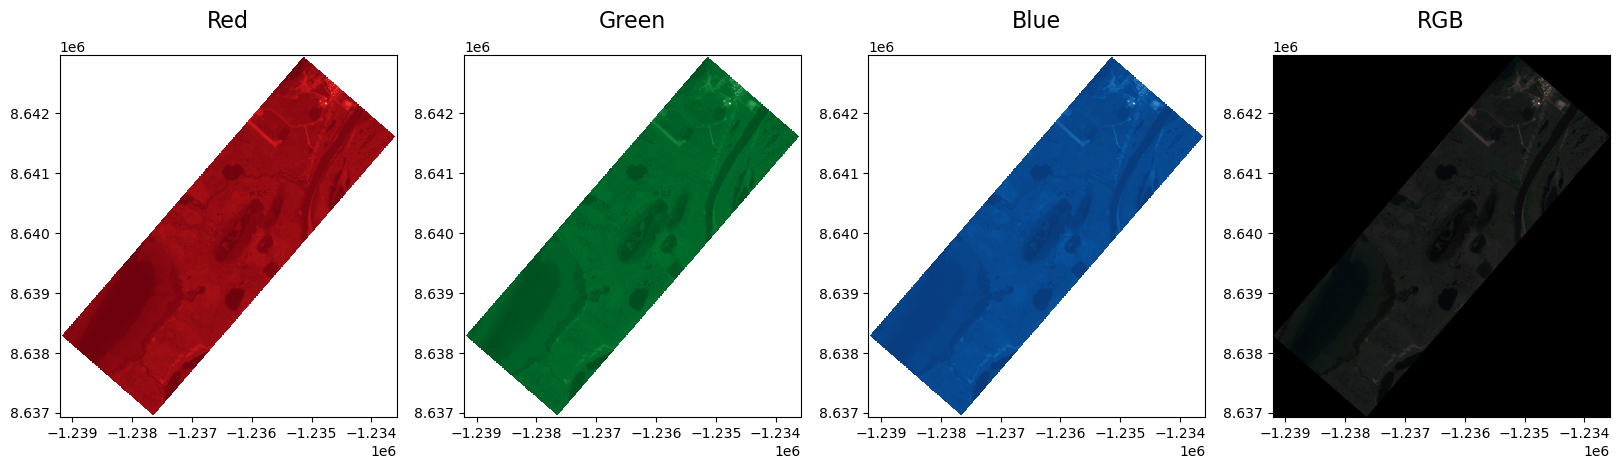

In [9]:
# a ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# Updated plotting to ignore NaN
fig1 = plt.figure()
for band, data in plotdict.items():
    clim = None if band == "RGB" else (0, 255)
    ax = fig1.add_subplot(gs[0, data['subplot']])
    
    # Plot with masking
    masked_array = np.ma.masked_where(data['array'] == 0, data['array'])  # mask NoData
    p = ax.imshow(masked_array, cmap=data['colormap'], clim=clim,
                  extent=[xmin, xmin + ncols * xres, ymax, ymax - nrows * yres])
    ax.set_title(band, pad=20, fontdict=titlefont)
    
plt.imshow(np.ma.masked_where(rgb_stack == 0, rgb_stack), extent=[xmin, xmin + ncols * xres, ymax, ymax - nrows * yres])
plt.show()

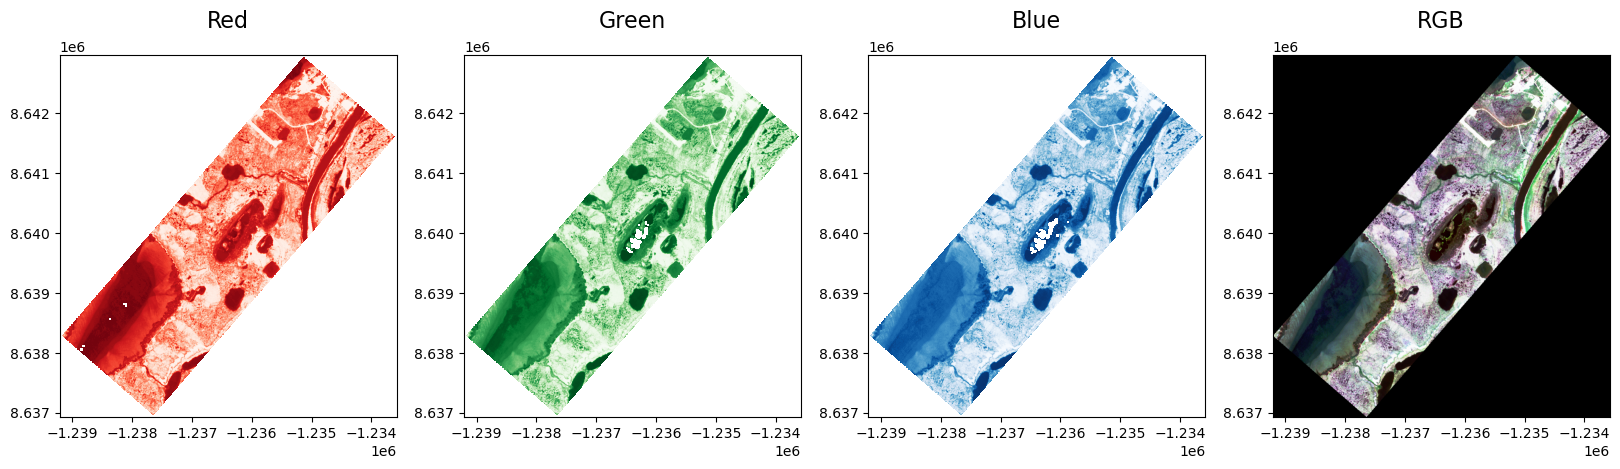

In [10]:
# Apply histogram equalization to each band in the RGB stack
for i in range(rgb_stack.shape[2]):
    # Extract the i-th band
    band = rgb_stack[:, :, i].copy()

    # Mask out NoData (0) values before equalizing
    mask = (band == 0)  # Assuming 0 represents NoData; adjust as necessary
    valid_pixels = band[~mask]  # Select only valid (non-NoData) pixels

    # Histogram equalization on non-NaN values only
    b_histogram, bins = np.histogram(valid_pixels, bins=256, range=[0, 255])
    b_cumdistfunc = b_histogram.cumsum()  # Compute cumulative distribution function
    b_cumdistfunc = 255 * b_cumdistfunc / b_cumdistfunc[-1]  # Normalize CDF

    # Apply interpolation to valid pixels only
    band_equalized = np.interp(valid_pixels, bins[:-1], b_cumdistfunc).astype('uint8')
    
    # Reinsert equalized values back into the original band while keeping NoData areas as 0
    band[~mask] = band_equalized
    rgb_stack[:, :, i] = band  # Update the RGB stack with equalized band

# Plotting using matplotlib
plt.rcParams['figure.figsize'] = [20, 20]
gs = gridspec.GridSpec(1, 4)

# Dictionary for plotting configurations
plotdict = {
    'Red': {'subplot': 0, 'array': rgb_stack[:, :, 0], 'colormap': 'Reds_r'},
    'Green': {'subplot': 1, 'array': rgb_stack[:, :, 1], 'colormap': 'Greens_r'},
    'Blue': {'subplot': 2, 'array': rgb_stack[:, :, 2], 'colormap': 'Blues_r'},
    'RGB': {'subplot': 3, 'array': rgb_stack, 'colormap': None}
}

# Plot individual bands and the combined RGB image
fig1 = plt.figure()
for band, data in plotdict.items():
    clim = None if band == "RGB" else (0, 255)  # Set color limits for single-band plots
    ax = fig1.add_subplot(gs[0, data['subplot']])

    # Apply masking to hide NoData values
    if band != "RGB":
        masked_array = np.ma.masked_where(data['array'] == 0, data['array'])  # Mask NoData areas
        p = ax.imshow(masked_array, cmap=data['colormap'], clim=clim,
                      extent=[xmin, xmin + ncols * xres, ymax, ymax - nrows * yres])
    else:
        masked_rgb = np.ma.masked_where(rgb_stack == 0, rgb_stack)  # Mask NoData areas in RGB stack
        p = ax.imshow(masked_rgb, extent=[xmin, xmin + ncols * xres, ymax, ymax - nrows * yres])
    
    ax.set_title(band, pad=20, fontdict=titlefont)

# Show the final RGB stack plot with equalization applied
plt.show()


In [11]:
# find bands nearest to NDVI red and nir wavelengths
ndvi_red, ndvi_nir = get_band_number(685), get_band_number(900)

# print band information from the table
print(str("\n"+"---"*20+"\n").join([str(ndvi_red),str(ndvi_nir)]))

# get the numpy arrays for the two bands
R685, R900 = get_band(ndvi_red), get_band(ndvi_nir)

# set fill value to numpy nan for all -9999.
R685[R685 == -9999.], R900[R900 == -9999.] = np.nan, np.nan

# calculate ndvi
ndvi_array = (R900-R685)/(R900+R685)

# print ndvi statistics
print(str("---"*20+"\n")+", ".join([
    "NDVI stats --- mean: "+str(np.nanmean(ndvi_array)), 
    "std: "+str(np.nanstd(ndvi_array)), 
    "min: "+str(np.nanmin(ndvi_array)), 
    "max: "+str(np.nanmax(ndvi_array)) 
]))

Band number                  63
Band center (nm)     687.259576
EM region           visible-red
Name: 63, dtype: object
------------------------------------------------------------
Band number                   105
Band center (nm)       897.619576
EM region           near-infrared
Name: 105, dtype: object
------------------------------------------------------------
NDVI stats --- mean: 0.33986795, std: 0.4347284, min: -0.76783913, max: 0.89312965


/var/folders/3m/0hcxmtys0jj01y_svh59k5fm0000gn/T/ipykernel_71788/683658233.py:14: RuntimeWarning: invalid value encountered in divide
  ndvi_array = (R900-R685)/(R900+R685)


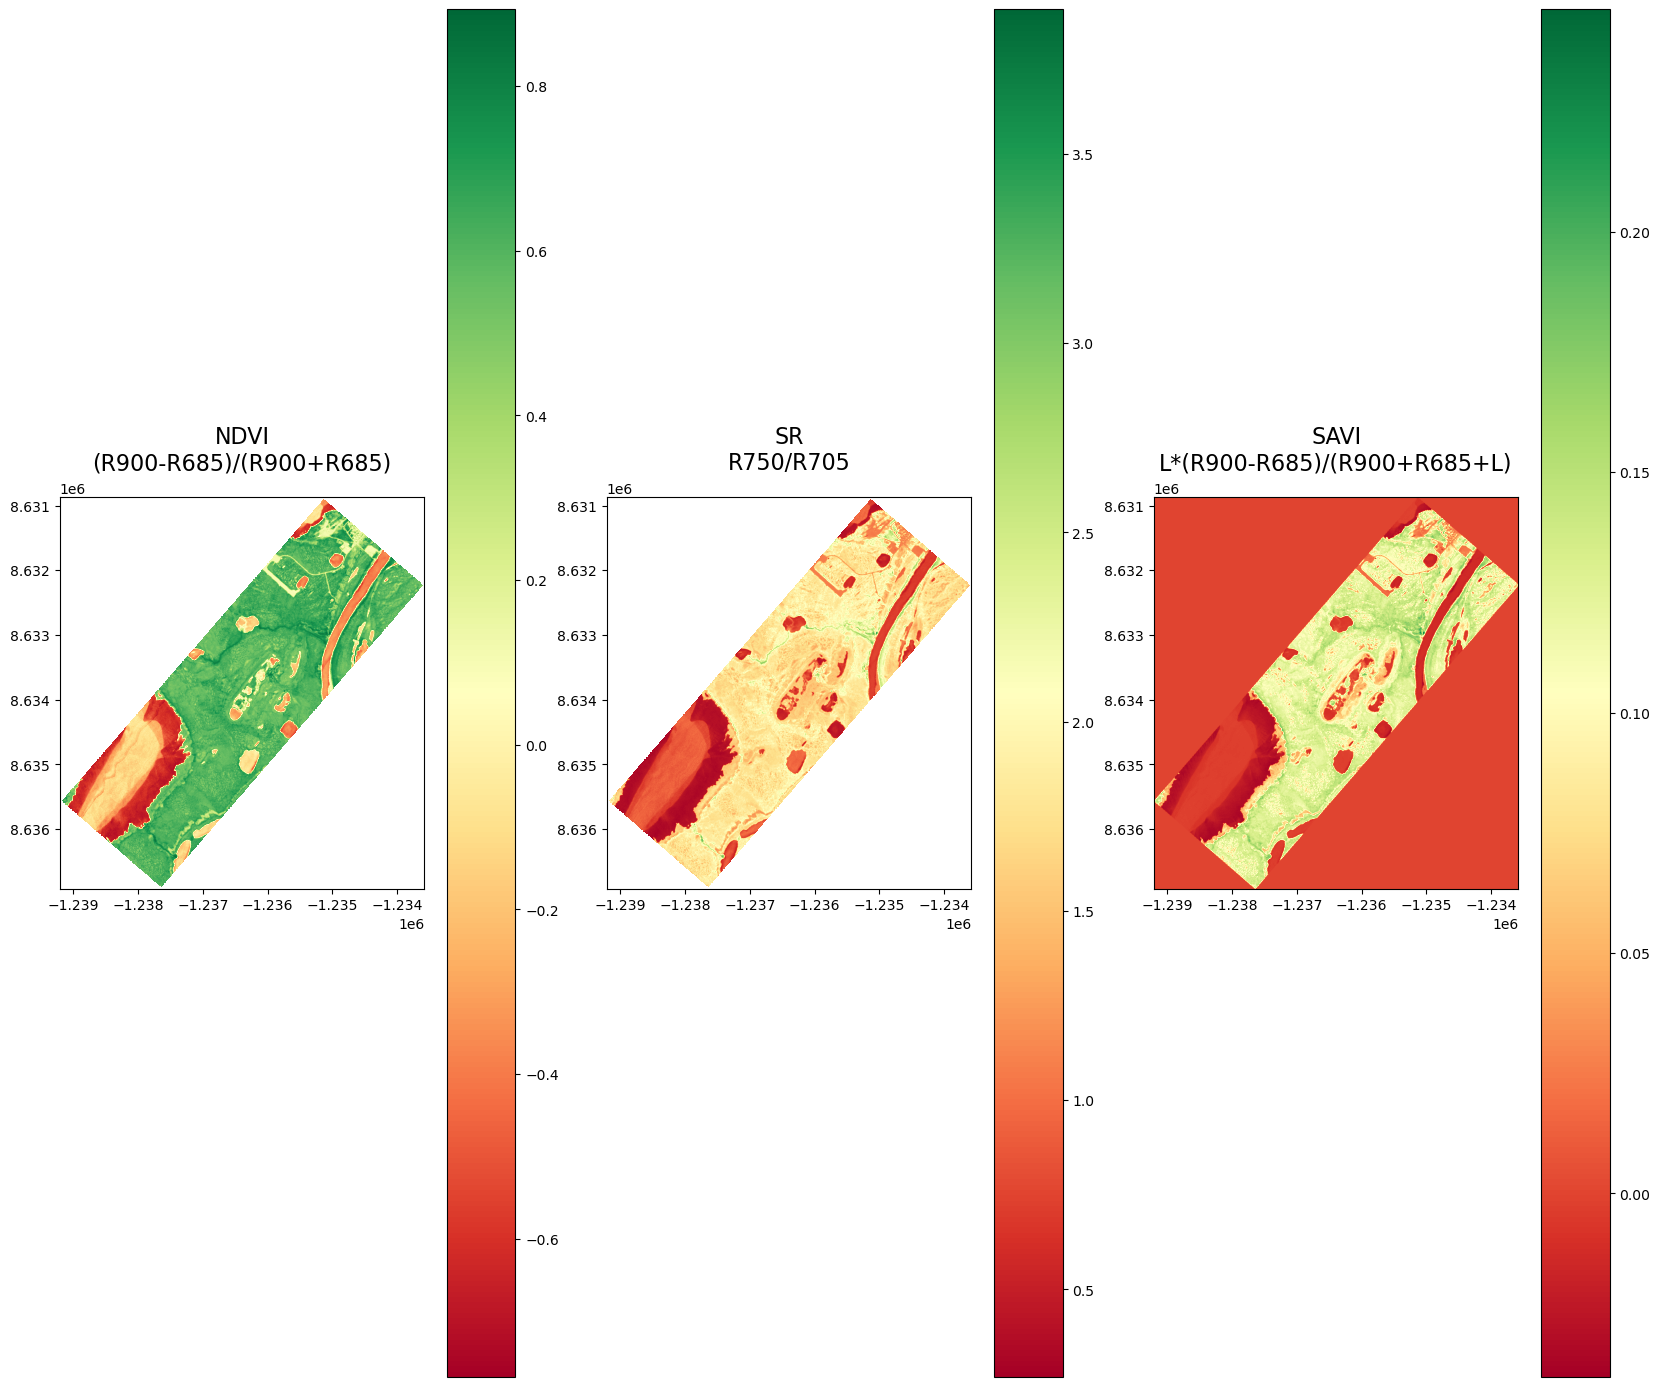

In [12]:
# get sr bands
R750, R705 = get_band(get_band_number(750)), get_band(get_band_number(705))
# set fill value to numpy nan for all -9999.
#R705[R705 == -9999.], R750[R750 == -9999.] = np.nan, np.nan
R705[R705 == 0.], R750[R750 == 0.] = np.nan, np.nan
# calculate sr
sr_array = R750/R705

# calculate savi
savi_array = 0.5*(R900-R685)/(R900+R685+0.5)

# plot. all of this is matplotlib ---------->
gs = gridspec.GridSpec(1, 3)

plotdict1 = { 'NDVI\n(R900-R685)/(R900+R685)': { 'subplot': 0, 'array': ndvi_array },
             'SR\nR750/R705': { 'subplot': 1, 'array': sr_array },
             'SAVI\nL*(R900-R685)/(R900+R685+L)': { 'subplot': 2, 'array': savi_array } }

# initialize plot and add ax element for each array in plotdict
fig2 = plt.figure()
for band,data in plotdict1.items():
    ax = fig2.add_subplot(gs[ 0, data['subplot'] ])
    p = ax.imshow(data['array'], cmap=plt.get_cmap("RdYlGn"),
                  extent=[xmin,xmin+ncols*xres,ymax,ymax+nrows*yres])
    ax.set_title(band, pad = 20, fontdict = titlefont)
    plt.colorbar(p)

## SAVI mask

In [13]:
# Step 1: Mask the SAVI values below 0.1
savi_masked = np.where(savi_array > 0.08, savi_array, np.nan)

# Define the output file name
#output_file = "savi_above_008.tif"
output_file = "python_mask/savi_above_008"

# Step 2: Set up a GDAL driver for GeoTIFF
#driver = gdal.GetDriverByName("GTiff")
driver = gdal.GetDriverByName("ENVI")

# Step 3: Create a new dataset with the same dimensions as `savi_array`
rows, cols = savi_array.shape
output_ds = driver.Create(output_file, cols, rows, 1, gdal.GDT_Float32)

# Check if dataset was created successfully
if output_ds is None:
    raise Exception("Could not create output dataset")

# Step 4: Set the geotransform and projection
output_ds.SetGeoTransform(img_open.GetGeoTransform())  # Copy geotransform from source
output_ds.SetProjection(img_open.GetProjection())      # Copy projection from source

# Step 5: Write the masked array to the output dataset
output_band = output_ds.GetRasterBand(1)
output_band.WriteArray(savi_masked)

# Set NoData value to ensure masked areas appear as transparent in GIS
output_band.SetNoDataValue(np.nan)

# Flush data and close dataset
output_band.FlushCache()
output_ds = None  # Close file

## NDVI mask

In [14]:
# Step 1: Mask the SAVI values below 0.1
ndvi_masked = np.where(ndvi_array > 0.3, ndvi_array, np.nan)

# Define the output file name
#output_file = "savi_above_008.tif"
output_file = "python_mask/ndvi_mask_above_03"

# Step 2: Set up a GDAL driver for GeoTIFF
#driver = gdal.GetDriverByName("GTiff")
driver = gdal.GetDriverByName("ENVI")

# Step 3: Create a new dataset with the same dimensions as `ndvi_array`
rows, cols = ndvi_array.shape
output_ds = driver.Create(output_file, cols, rows, 1, gdal.GDT_Float32)

# Check if dataset was created successfully
if output_ds is None:
    raise Exception("Could not create output dataset")

# Step 4: Set the geotransform and projection
output_ds.SetGeoTransform(img_open.GetGeoTransform())  # Copy geotransform from source
output_ds.SetProjection(img_open.GetProjection())      # Copy projection from source

# Step 5: Write the masked array to the output dataset
output_band = output_ds.GetRasterBand(1)
output_band.WriteArray(ndvi_masked)

# Set NoData value to ensure masked areas appear as transparent in GIS
output_band.SetNoDataValue(np.nan)

# Flush data and close dataset
output_band.FlushCache()
output_ds = None  # Close file